<a href="https://colab.research.google.com/github/grantinator/colab/blob/main/makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt -O names.txt

--2025-07-21 22:27:55--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-21 22:27:55 (6.20 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open("names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
#NOTES
emb = C[X]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # logits are like unnormalized votes across output. negative to positive numbers
# counts = logits.exp() <- make all the votes positive
# probs = counts / counts.sum(dim=1, keepdims=True) <- normalize them into probabilities
# loss = -probs[torch.arange(32), Y].log().mean() <- For each example (row), we want to see the probability we assigned to the true label for input 0, y=5 -> get preds[0, 5]. Log to make summable then calc mean for loss.
# <Equivalent to below>
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [ ]:
def build_dataset(words):
  block_size = 3 # context legnth: how many characters do we take to predict next
                  # e.g <block_size>-gram

  X, Y = [], []

  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

In [ ]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
n_embed = 10 # 10-dimensional embeddings
n_hidden = 200 # size of hidden layer
block_size = 3 # number of words in input
vocab_size = len(itos)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g) # 27 chars -> 10 dim embeddings
# W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * ((5/3) / ((n_embed * block_size)**0.5)) # KAIMING INIT num input chars * embedding_size -> hidden_layer_isze
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
# b1 = torch.randn(n_hidden, generator=g) * 0.01 # NOt necessary in batchnorm as this is just subtracted off by batchnorm
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # hidden_layer size -> output size (vocab)
b2 = torch.randn(vocab_size, generator=g) * 0

# Batchnorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum([p.nelement() for p in parameters]))
for p in parameters:
  p.requires_grad = True


NameError: name 'b1' is not defined

In [ ]:
NUM_TRAINING_ITERS = 50000
batch_size = 32
lre = torch.linspace(-3, 0, NUM_TRAINING_ITERS) # 10*-3 = 0.001 10**0 = 1 search
lrs = 10**lre
lrs = torch.flip(lrs, dims=(0,))
lossi = []

In [ ]:
for i in range(NUM_TRAINING_ITERS):
  # Construct minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  #forward pass
  # --------------------------------------------
  emb = C[Xb] # (batch_size, block_size, n_embed)
  embcat = emb.view(emb.shape[0], block_size * n_embed) # concat
  hpreact = embcat @ W1 + # b1 we don't need bias with batch norm. b1 would just be subtracted out as part of bnmeani.

  # batch-norm layer
  # --------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # nonlineariy
  # --------------------------------------------
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # backward
  for p in parameters:
    p.grad = None

  loss.backward()
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f"{i:7d}/{NUM_TRAINING_ITERS}: {loss.item():.4f}")

  # Track stats
  lossi.append(loss.log10().item())


      0/50000: 3.7807
  10000/50000: 2.4517
  20000/50000: 2.8321
  30000/50000: 2.1966
  40000/50000: 2.5145


In [ ]:
# Now the model depends on a batch to calculate the mean/std for batch norm. But in
# production we're just going to plug in one example and so there will be no batch.
# So we calibrate it one last time at the end of training across the entire training set.
with torch.no_grad():
  emb = C[Xtr] # Use whole training set, no batch
  embcat = emb.view(emb.shape[0], block_size * n_embed) #concate embeddings
  hpreact = embcat @ W1 + b1
  # Measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)




In [ ]:
@torch.no_grad()
def split_loss(split):
  splits = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte)
  }
  x, y = splits[split]
  emb = C[x]
  hpreact = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('dev')


NameError: name 'b1' is not defined

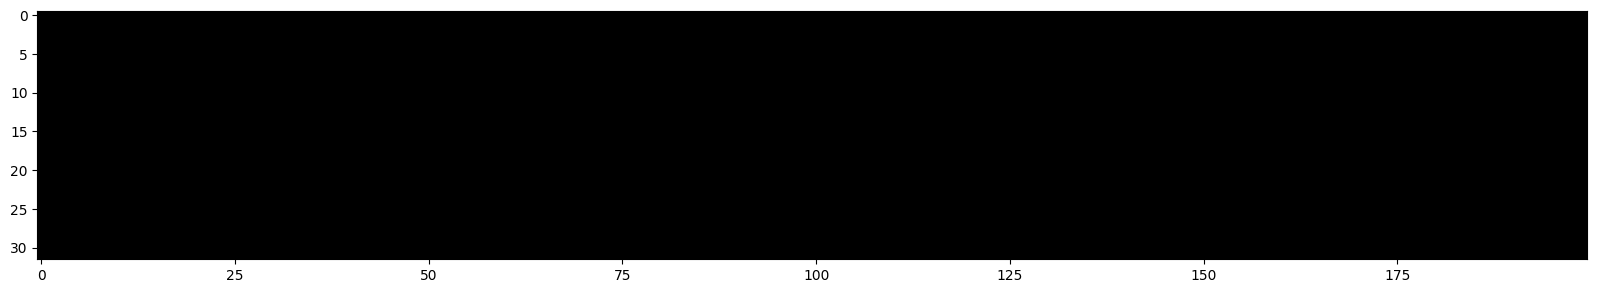

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

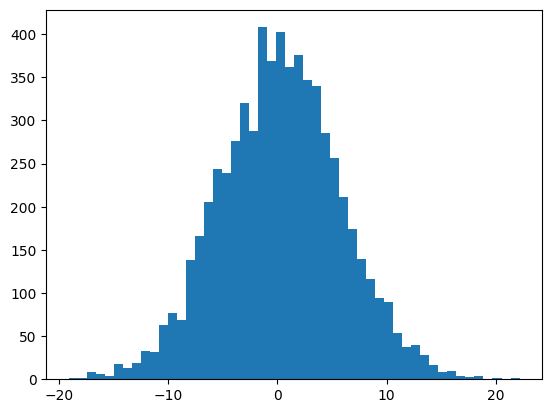

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [ ]:
(5/3) / ((n_embed * block_size)**0.5)

0.3042903097250923

torch.Size([1000, 200])
tensor(-0.0122) tensor(1.0031)
tensor(-0.0027) tensor(0.9946)


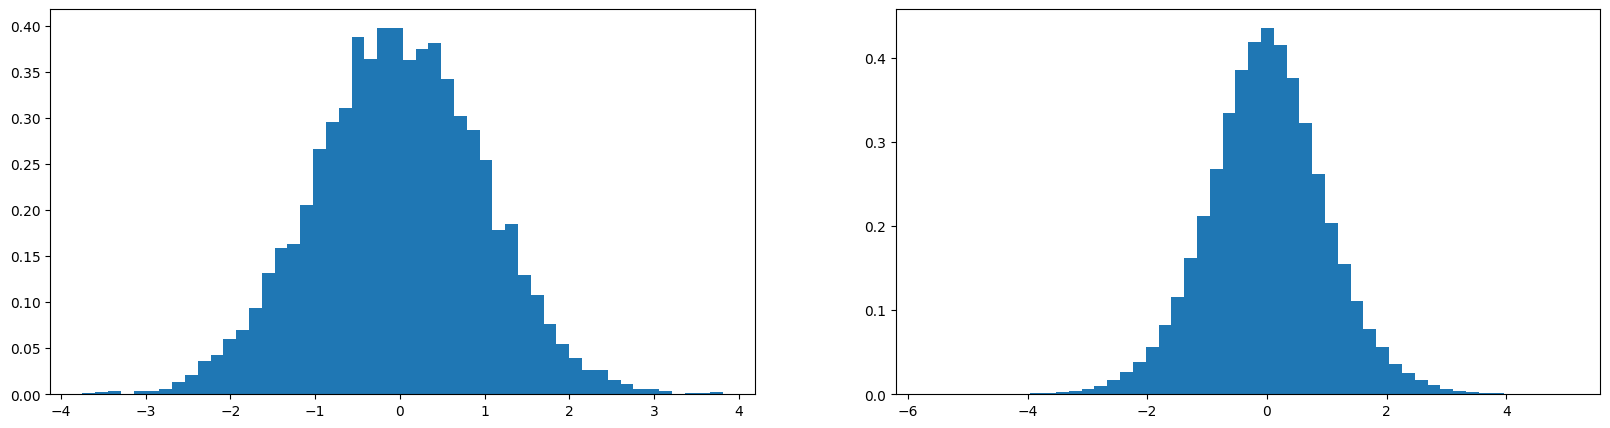

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10**0.5)
y = x @ w
print(y.shape)
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # khaming init or whatever its called. Prescale the weights so that when we do X @ W the activations are unit normal.
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if not self.bias is None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained) as part of gamma * batchNorm + beta to be learned
    # Start at 1 and zero so initialized values are unit normal but gamma and beta
    # can be learned away from forcing activations to unit normal
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # running mean and variance for predictions
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # mean for each neuron across all examples
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # batch norm formula [https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html]
    self.out = self.gamma * xhat + self.beta
    # Update running mean/std if in traning mode
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

n_embd = 10 # dimensionality of each char's embedding
n_hidden = 100 # the number of neurons in the hidden layer
block_size = 3 # number of characters in input layer
g = torch.Generator().manual_seed(2147483647)

In [ ]:
C = torch.randn((vocab_size, n_embd),  generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  # last layer: make it less confident (for initialization make it closer to uniform distribution)
  layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= (5/3) #(5/3) # kaiming init to make X @ W activations more unit normal at start

parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
  p.requires_grad = True


In [ ]:
NUM_TRAINING_ITERS = 20000
batch_size = 32
lossi = []
beta1 = 0.9
beta2 = 0.999

mu_i = [torch.zeros_like(p) for p in parameters]
v_i = [torch.zeros_like(p) for p in parameters]

eps = 1e-8

In [ ]:
for epoch in range(NUM_TRAINING_ITERS):
  t = epoch + 1
  # Construct minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  #forward pass
  # --------------------------------------------
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1) # concatenate embeddigns into n_sample vectors of vocab * dim_size
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb) # loss function


  for layer in layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad = None

  loss.backward()

  # lr = 0.1 if i < 100000 else 0.01
  lr = 0.001
  for i, p in enumerate(parameters):
    mt = beta1 * mu_i[i] + (1-beta1) * p.grad
    vt = beta2 * v_i[i] + (1-beta2) * p.grad**2

    mu_i[i] = mt # setting moving average to latest average
    v_i[i] = vt

    # Correct terms
    muhat = mt / (1 - beta1**t)
    vhat = vt / (1 - beta2**t)

    denom = torch.sqrt(vhat) + eps
    update = muhat / denom
    # p.data += -lr * p.grad
    p.data += -lr * (muhat / (vhat**0.5 + eps))

  if t % 10000 == 0:
    print(f"{t:7d}/{NUM_TRAINING_ITERS}: {loss.item():.4f}")


  # Track stats
  lossi.append(loss.log10().item())



  10000/20000: 2.3079
  20000/20000: 2.4539


In [ ]:
@torch.no_grad()
def split_loss(split):
  splits = {
      'train': (Xtr, Ytr),
      'test': (Xte, Yte),
      'dev': (Xdev, Ydev)
  }
  x, y = splits[split]
  emb = C[x]
  x = emb.view(emb.shape[0], -1) # concatenate embeddigns into n_sample vectors of vocab * dim_size
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, y)

  print(split, loss.item())

split_loss('test')
split_loss('dev')

test 2.1694960594177246
dev 2.1628615856170654


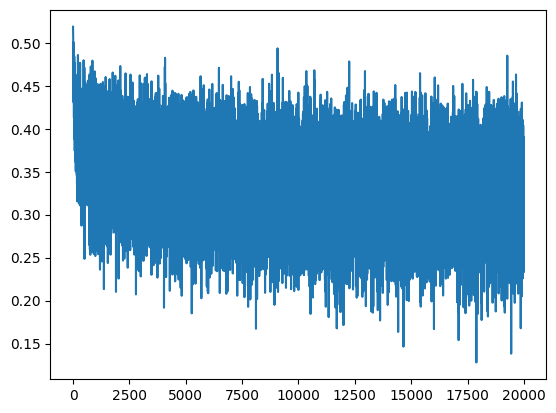

In [ ]:
plt.plot(torch.arange(0, len(lossi)), lossi)
# print(lossi[:5])

layer 1 (      Tanh): mean +0.02, std 0.83, saturated: 37.12%
layer 3 (      Tanh): mean +0.00, std 0.85, saturated: 44.41%
layer 5 (      Tanh): mean -0.06, std 0.87, saturated: 50.44%
layer 7 (      Tanh): mean +0.00, std 0.91, saturated: 56.66%
layer 9 (      Tanh): mean -0.02, std 0.92, saturated: 61.09%


Text(0.5, 1.0, 'activation distribution')

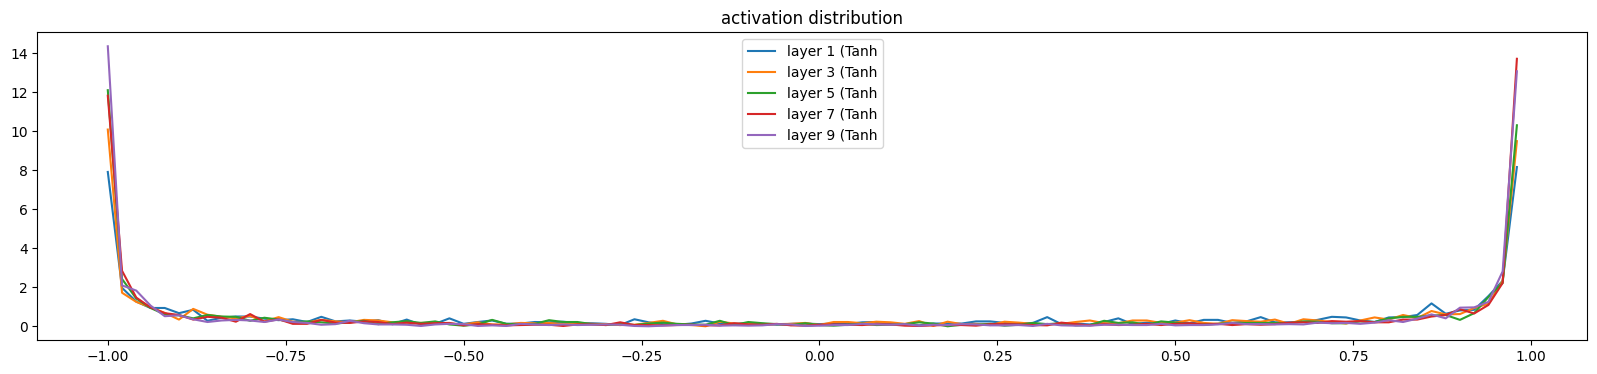

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.05, std 0.75, saturated 19.44%
layer 3 (      Tanh): mean +0.02, std 0.69, saturated 9.44%
layer 5 (      Tanh): mean -0.01, std 0.67, saturated 6.59%
layer 7 (      Tanh): mean -0.03, std 0.65, saturated 6.00%
layer 9 (      Tanh): mean -0.00, std 0.65, saturated 5.19%


Text(0.5, 1.0, 'activation distribution')

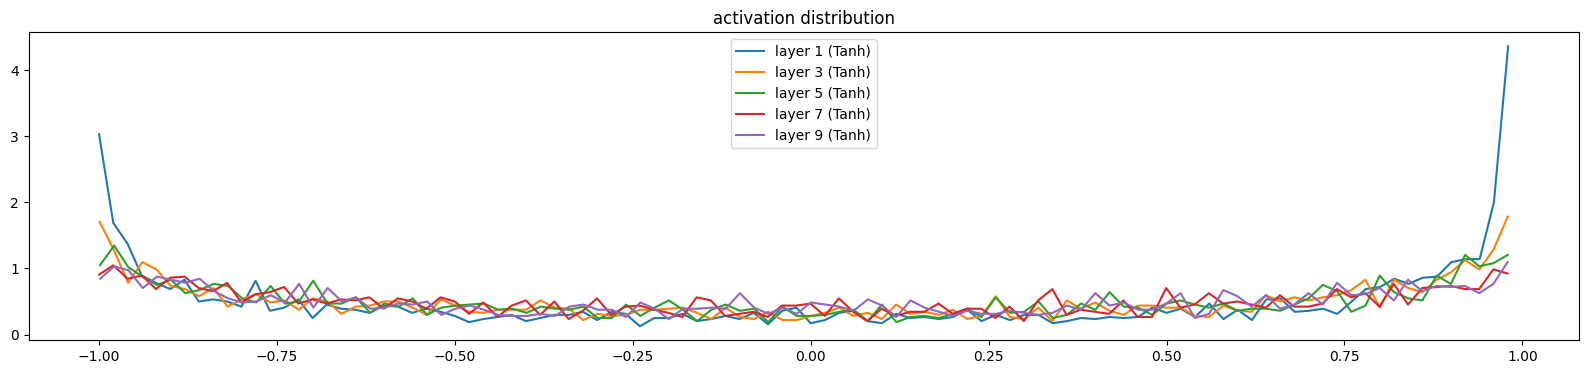

In [ ]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out # Activation of this layer
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distribution')

